In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import math
from sklearn.cluster import KMeans
from scipy import ndimage
from scipy.spatial import distance
from tqdm.notebook import tqdm
import pickle
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
# conda install -c conda-forge cyvlfeat
from cyvlfeat.sift.dsift import dsift
from cyvlfeat.kmeans import kmeans

Using TensorFlow backend.


In [2]:
def get_images(path, size, Normalize=False):
    total_pic = {}
    for doc in os.listdir(path):
        tmp = []
        for file in os.listdir(os.path.join(path, doc)):      
            
            if file.endswith(".jpg"):
                img = cv2.imread(os.path.join(path, doc, file), cv2.IMREAD_GRAYSCALE)
                pic = cv2.resize(img, (size, size))
                if Normalize:
                    pic = pic / 255.0
                tmp.append(pic)
        total_pic[doc] = tmp
    return total_pic

In [3]:
SIZE = 128

In [4]:
train = get_images('./hw5_data/train/', SIZE, True)
test = get_images('./hw5_data/test/', SIZE, True)

In [5]:
datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

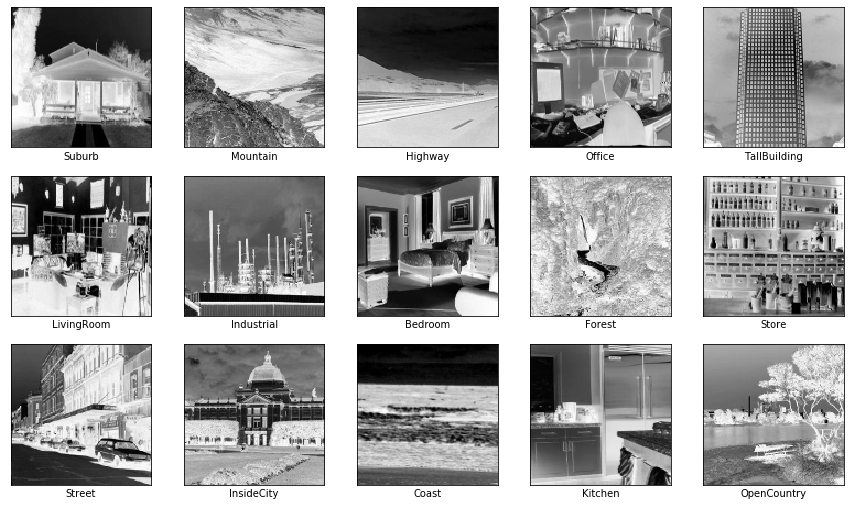

In [6]:
class_names = list(train.keys())

plt.figure(figsize=(15,15))
for i in range(len(class_names)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[class_names[i]][0], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[i])
plt.show()

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation="relu", input_shape=(SIZE, SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))


# FC layers
model.add(layers.Flatten())    
model.add(layers.Dense(512, activation='relu'))    
model.add(layers.Dropout(0.5))
model.add(layers.Dense(15, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [8]:
def get_cnndata(datadict):
    images=[]
    labels=[]
    for key, value in datadict.items():
        for img in value:
            labels.append(key)
            images.append(img)
    return np.array(images), np.array(labels)

In [9]:
train_images, train_labels = get_cnndata(train)
test_images, test_labels = get_cnndata(test)

In [10]:
train_images = train_images.reshape([train_images.shape[0], train_images.shape[1], train_images.shape[2], 1])
test_images = test_images.reshape([test_images.shape[0], test_images.shape[1], test_images.shape[2], 1])

In [11]:
CATEGORIES = list(train.keys())
cat_dict = {}
for i, cat in enumerate(CATEGORIES):
    cat_dict[cat] = i
def onehot(labels):
    res = []
    for cat in labels:
        tmp = np.zeros(15)
        tmp[cat_dict[cat]] = 1
        res.append(tmp)
    return np.array(res)

In [12]:
train_labels = onehot(train_labels)
test_labels = onehot(test_labels)

In [13]:
batch_size = 16
steps_per_epoch=int((len(train_images)*5)/batch_size)

In [14]:
datagen.fit(train_images)

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit_generator(datagen.flow(train_images,  
      train_labels, batch_size=batch_size),
      steps_per_epoch=steps_per_epoch,
            epochs=50, validation_data=(test_images, test_labels))

Epoch 1/50
468/468 [==============================] - 12s 26ms/step - loss: 2.5186 - accuracy: 0.1454 - val_loss: 1.9513 - val_accuracy: 0.3467
Epoch 2/50
468/468 [==============================] - 11s 24ms/step - loss: 2.0958 - accuracy: 0.2953 - val_loss: 1.5728 - val_accuracy: 0.4800
Epoch 3/50
468/468 [==============================] - 11s 24ms/step - loss: 1.8547 - accuracy: 0.3826 - val_loss: 1.5654 - val_accuracy: 0.4533
Epoch 4/50
468/468 [==============================] - 11s 24ms/step - loss: 1.7330 - accuracy: 0.4171 - val_loss: 1.3067 - val_accuracy: 0.5733
Epoch 5/50
468/468 [==============================] - 11s 24ms/step - loss: 1.6129 - accuracy: 0.4661 - val_loss: 1.2824 - val_accuracy: 0.5333
Epoch 6/50
468/468 [==============================] - 11s 24ms/step - loss: 1.5256 - accuracy: 0.4920 - val_loss: 1.3560 - val_accuracy: 0.5867
Epoch 7/50
468/468 [==============================] - 11s 24ms/step - loss: 1.4926 - accuracy: 0.5051 - val_loss: 1.2361 - val_accuracy:

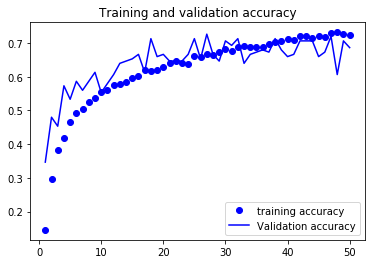

In [15]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

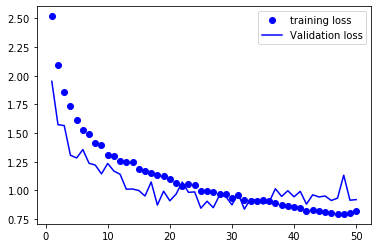

In [16]:
plt.figure()
plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.legend()

plt.show()